In [1]:
import os

In [2]:
os.chdir('../')
%pwd

'/home/paladin/Downloads/Bixi-OD-Matrix-Prediction/Bixi-OD-Matrix-Prediction'

In [3]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class AutoencoderEvaluationConfig:
    trained_od_model_path: Path
    trained_tensor_model_path: Path       
    test_od_data: Path
    test_tensor_data: Path 
    scaler_od: Path
    scaler_tensor: Path   
    params_od_size: list
    params_tensor_size: list
   

In [4]:
from timeseriesPredictor.utils import read_yaml, create_directories
from timeseriesPredictor.constants import *

In [5]:
class configurationManeger:
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH,
                 secret_filepath = SECRET_FILE_PATH,                 
                 params_filepath = PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath) 
        self.secret = read_yaml(secret_filepath)        
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])
   
    
    def get_autoencoder_evaluation_config(self) -> AutoencoderEvaluationConfig:        

        autoencoder_evaluation_config = AutoencoderEvaluationConfig(
        trained_od_model_path= self.config.training_autoencoder.trained_od_model_path,
        trained_tensor_model_path= self.config.training_autoencoder.trained_tensor_model_path, 
        test_od_data = self.config.data_transformation.local_test_od_dir,
        test_tensor_data = self.config.data_transformation.local_test_tensor_dir,
        scaler_od= self.config.data_transformation.local_scaler_od_dir,
        scaler_tensor= self.config.data_transformation.local_scaler_tensor_dir,                     
        params_od_size= self.params.OD_SIZE,
        params_tensor_size=self.params.TENSOR_SIZE,
                     
        )

        return autoencoder_evaluation_config

In [6]:
import keras
import pickle
from timeseriesPredictor.utils import evaluate_forecasts, save_json
from timeseriesPredictor.logger import logging

2023-08-14 17:39:07.616873: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 17:39:07.676832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 17:39:07.677678: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 17:39:08.752429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
class AutoencoderEvaluation:
    def __init__(self, config: AutoencoderEvaluationConfig):
        self.config = config

    
    @staticmethod
    def get_trained_model(path:Path):
        model = keras.models.load_model(path)
        return model  

    @staticmethod
    def load_pickle_file(path: Path):
        file= open(path, 'rb')
        obj = pickle.load(file)
        return obj
    
    def save_score(self):
        scores = {'Average RMSE': self.best_rmse, 'Average MAE': self.best_mae}
        save_json(path='autoencoder_scores.json', data=scores)
    
    def evaluation(self):
        X_tests = [self.load_pickle_file(self.config.test_od_data) , self.load_pickle_file(self.config.test_tensor_data)]
        scalers = [self.load_pickle_file(self.config.scaler_od) , self.load_pickle_file(self.config.scaler_tensor)]
        trained_model_paths = [self.config.trained_od_model_path, self.config.trained_tensor_model_path] 
        
        best_rmse = 100000
        for trained_model_path, X_test , scaler in zip(trained_model_paths, X_tests, scalers):
            model = self.get_trained_model(trained_model_path)
            prediction = model.predict(X_test)
            l,m,n,_ = prediction.shape
            pred_test = prediction.reshape(l,m*n)
            true_test = X_test.reshape(l,m*n)
            avg_mae, _ , avg_rmse, _ = evaluate_forecasts(scaler.inverse_transform(true_test), scaler.inverse_transform(pred_test), "Test")
            
            if best_rmse> avg_rmse:
               self.best_rmse = avg_rmse
               self.best_mae = avg_mae
               best_autoencoder_path = trained_model_path
        
        logging.info(f'Best autoencoder model based on the least average RMSE is stored at: {best_autoencoder_path}') 

In [8]:
import sys
from timeseriesPredictor.exception import CustomException

7/7 [==============================] - 1s 56ms/step
#### Evaluating performance metrics ####

====Test SET ====
MAE: 2.294
RMSE: 8.347
MAEs:  [2.502 0.703 0.075 ... 0.687 1.009 2.168]
RMSEs:  [3.911 0.97  0.205 ... 0.82  1.373 3.112]


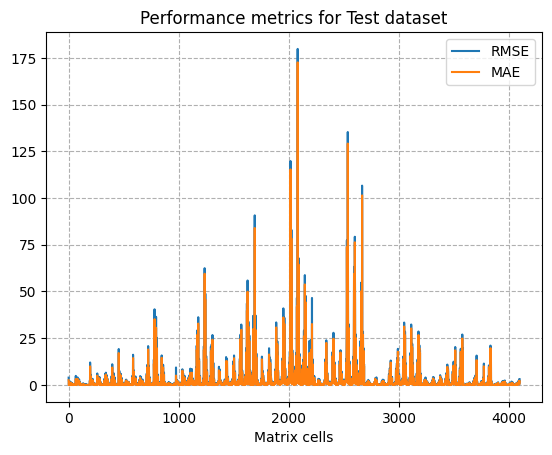

7/7 [==============================] - 1s 72ms/step
#### Evaluating performance metrics ####

====Test SET ====
MAE: 1.239
RMSE: 5.595
MAEs:  [2.462e+00 7.830e-01 7.400e-02 ... 2.000e-03 4.000e-03 5.000e-03]
RMSEs:  [4.211e+00 1.216e+00 1.690e-01 ... 2.000e-03 4.000e-03 5.000e-03]


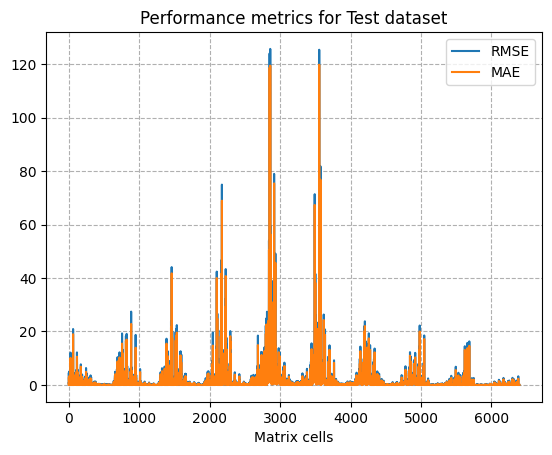

In [9]:
try:
    config = configurationManeger()
    evaluation_config = config.get_autoencoder_evaluation_config()
    evaluation = AutoencoderEvaluation(evaluation_config)
    evaluation.evaluation()
    evaluation.save_score()
except Exception as e:
    raise CustomException(e, sys)